# RNN for Engine Dataset

In [246]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [247]:
train_file = np.loadtxt("../data/processed/processed_rnn_train_FD001.txt",delimiter=",",skiprows=1)
test_file  = np.loadtxt("../data/processed/processed_rnn_test_FD001.txt",delimiter=",",skiprows=1)
#,unit,RUL,os 1,os 2,os 3,sm 1,sm 2,sm 3,sm 4,sm 5,sm 6,sm 7,sm 8,sm 9,sm 10,sm 11,sm 12,sm 13,sm 14,sm 15,sm 16,sm 17,sm 18,sm 19,sm 20,sm 21
train_file = train_file[:,1:]
test_file = test_file[:,1:]

scaler = MinMaxScaler()
scaler.fit(train_file[:,1:])
train_file[:,1:] = scaler.transform(train_file[:,1:])
test_file[:,1:] = scaler.transform(test_file[:,1:])


In [248]:
print(train_file.shape)

(20631, 26)


In [249]:
import random

# convert time series data for 1 unit to tensor along with RUL (always 0)
def getUnitData(data,i):
    ind = np.where(data[:,0] == i)
    ind = ind[0]
    num_lines = ind.size
    num_features = data.shape[1] - 2
    data_tensor = torch.zeros(num_lines,1,num_features)
    last_ind = ind[-1]
    for t in range(num_lines):
        for i in range(num_features):
            data_tensor[t][0][i] = float(data[ind[t],2+i])
    rul_tensor = torch.tensor(data[:,1],dtype=torch.float)

    return data_tensor,rul_tensor

# subsample a section of a unit data so not all training targets are 0
def sampleData(data,maxUnits):
    unit_num = random.randint(1,maxUnits)
    data,rul = getUnitData(data,unit_num)
    last_step = data.size()[0]

    # minimum size for training series
    min_steps = 15
    max_steps = 100

    #select random starting index and length for training example
    start = random.randint(0,max_steps-min_steps)
    length = random.randint(min_steps,max_steps)
    end = min(start+length,last_step)
    length = start - end

    data = data[start:end]
    rul = rul[start:end]

    return data,rul


In [250]:
# print(getUnitData(train_file,1)[1])
print(sampleData(train_file,100)[1])

tensor([0.4488, 0.4460, 0.4432, 0.4404, 0.4377, 0.4349, 0.4321, 0.4294, 0.4266,
        0.4238, 0.4211, 0.4183, 0.4155, 0.4127, 0.4100, 0.4072, 0.4044, 0.4017,
        0.3989, 0.3961, 0.3934, 0.3906, 0.3878, 0.3850, 0.3823, 0.3795, 0.3767,
        0.3740, 0.3712, 0.3684, 0.3657, 0.3629, 0.3601, 0.3573, 0.3546, 0.3518,
        0.3490, 0.3463, 0.3435, 0.3407, 0.3380, 0.3352, 0.3324, 0.3296, 0.3269,
        0.3241, 0.3213, 0.3186, 0.3158, 0.3130, 0.3102, 0.3075, 0.3047, 0.3019])


In [251]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Design Network

In [252]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,n_layers):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.rnn = nn.RNN(input_size,hidden_size,n_layers)
        self.fc = nn.Linear(hidden_size,output_size)

    def forward(self, input):
        hidden = self.initHidden()

        output,hidden = self.rnn(input,hidden)

        output = output.contiguous().view(-1,self.hidden_size)
        output = self.fc(output)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.n_layers,1, self.hidden_size).to(device)

n_features = 24
n_hidden = 48
n_layers = 4
n_output = 1
rnn = RNN(n_features, n_hidden, n_output, n_layers)
rnn = rnn.to(device)

loss_fn = nn.L1Loss()
learning_rate = 1e-5
optimizer = torch.optim.Adam(rnn.parameters(),lr=learning_rate)

In [253]:
def train(data,target):
    optimizer.zero_grad()
    data.to(device)

    output,hidden = rnn(data)
    
    loss = loss_fn(torch.squeeze(output),target)
    loss.backward()
    optimizer.step()

    return output,loss.item()

In [254]:
maxUnits = int(np.max(train_file[:,0]))

input,rul = getUnitData(train_file,1)
print(input.size())

# hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input.to(device))
# print(output)

torch.Size([192, 1, 24])


## Training

In [267]:
import time
import math

n_iters = 1000
print_every = 500
plot_every = 500

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    rnn.train()
    data,rul = sampleData(train_file,maxUnits)

    data = data.to(device)
    rul = rul.to(device)

    output, loss = train(data,rul)

    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        # guess, guess_i = categoryFromOutput(output)
        # correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d%% (%s) %.4f' % (iter / n_iters * 100, timeSince(start), loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

50% (0m 14s) 0.0856
100% (0m 27s) 0.0496


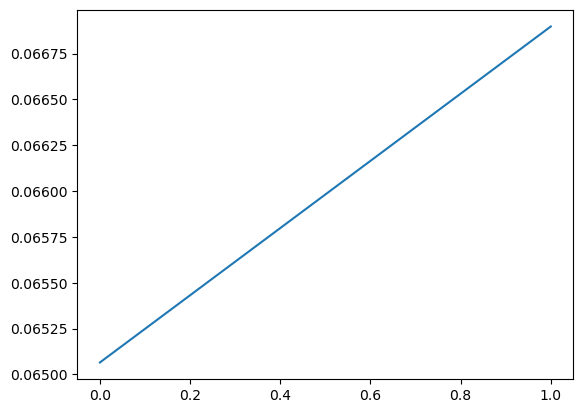

In [268]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
# plt.ylim([0,5000])

## Testing Model Performance

In [269]:
def evaluate(input):
    with torch.no_grad():
        # hidden = rnn.initHidden()

        # for t in range(input.size()[0]):
        rnn.eval()
        output,hidden = rnn(input)
    
    return output

def predict(input):
    output = evaluate(input)

    return output

In [272]:
n_train = 100
error = np.zeros((n_train,1))
for i in range(n_train):
    data,rul = sampleData(train_file,maxUnits)
    data = data.to(device)
    rul = rul.to(device)
    pred = predict(data)
    print(pred[-1].cpu())
    error[i] = ((pred[-1] - rul[-1]).cpu())
print(error)

tensor([0.2342])
tensor([0.2734])
tensor([0.2967])
tensor([0.2786])
tensor([0.2414])
tensor([0.2690])
tensor([0.3231])
tensor([0.3071])
tensor([0.2528])
tensor([0.2615])
tensor([0.3117])
tensor([0.2876])
tensor([0.2676])
tensor([0.3317])
tensor([0.2878])
tensor([0.3074])
tensor([0.2670])
tensor([0.2453])
tensor([0.2622])
tensor([0.2743])
tensor([0.2916])
tensor([0.3115])
tensor([0.2741])
tensor([0.2810])
tensor([0.2819])
tensor([0.3160])
tensor([0.2625])
tensor([0.3178])
tensor([0.2530])
tensor([0.2803])
tensor([0.3327])
tensor([0.3132])
tensor([0.3359])
tensor([0.2445])
tensor([0.2895])
tensor([0.2680])
tensor([0.3217])
tensor([0.2312])
tensor([0.2741])
tensor([0.2911])
tensor([0.3311])
tensor([0.2465])
tensor([0.3155])
tensor([0.2910])
tensor([0.2566])
tensor([0.2600])
tensor([0.2077])
tensor([0.2304])
tensor([0.3083])
tensor([0.3031])
tensor([0.2651])
tensor([0.3310])
tensor([0.2722])
tensor([0.2692])
tensor([0.2773])
tensor([0.2294])
tensor([0.2771])
tensor([0.3065])
tensor([0.2852

23.966045012921096


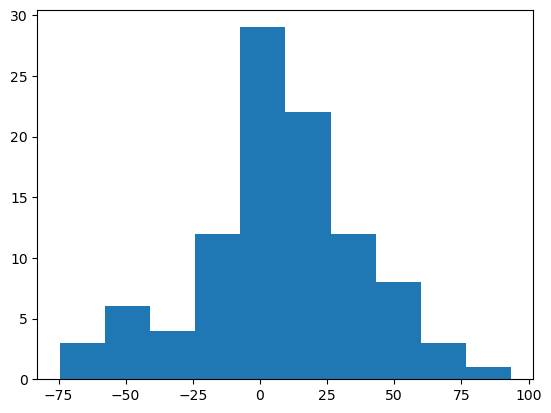

In [273]:
err = np.zeros((n_train,25))
err[:,0] = error[:,0]
err = scaler.inverse_transform(err)
error = err[:,0]
plt.hist(error)
print(np.average(np.abs(error)))